<a href="https://colab.research.google.com/github/Kevindx98/FSI-CNN-FacialAge/blob/master/Facial_Age.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocedor de Edad Facial

Se va a tratar de estudiar una **Red Neuronal Convolutiva**  que sea capaz de reconocer la Edad Facial de una persona dada su foto. 

## Requisitos
- Dicha foto, para que funcione dicha CNN deberá ser lo más parecida a una foto de Carnet.
- Nuestra CNN podrá reconocer, en principio, 6 intervalos de edad cerrados (Los relatados según [*minsalud*](https://www.minsalud.gov.co/proteccionsocial/Paginas/cicloVida.aspx) ), entre los que se incluyen:
```java
1) Primera Infancia (1-5 años)
2) Infancia (6-12 años)
3) Adolescencia (13-18 años)
4) Juventud (19-25 años)
5) Adultez (26-60 años)
6) Persona Mayor (+60 años)
```
- Evidentemente el DataSet usado debe estar en el directorio al cual nuestro código va a apuntar para formar el Modelo. En mi caso, utilizaré Google Drive para almacenarlo.

## Notas
- El DataSet se ha obtenido de 'Kaggle'. Tiene como nombre ''*face-age*''.
- El DataSet fue modificado de dos formas. La primera de ellas, para formar los rangos de edad antes expuestos (El dataset original dividía las edades individualmente y nosotros queremos que ésto sea por rango). La segunda forma fue para quitar aquellas fotos que no cumplían los requisitos mencionados previamente (Foto borrosa, inadecuada, con marca de agua...)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

### Comprobación de que el DataSet se ha importado correctamente:

1  2  3  4  5  6


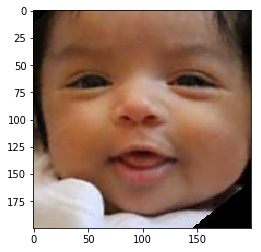

In [52]:
!ls "/content/drive/My Drive/Colab Notebooks/datasets/facial_age"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/1/4882.png', 'r')
imshow(np.asarray(pil_im))

### Comprobación de la GPU utilizada:

In [53]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

 ## Primera Idea de Modelo: 
 
 Para la primera versión de nuestra CNN:
 - Los datos de Entrenamiento tendrán un reescalado en sus píxeles a un valor [0-1]. Además, sufrirán un rotado y un zoom.
 - Se generarán dos tipos de datos: *Train* y *Validation*. Uno servirá para entrenar nuestra CNN y el otro para que, a raíz de los entrenamientos de cada Epoch, se trate de mejorar el *accuracy* reduciendo *Overfitting*. Se debe tener en cuenta que las fotos tienen unas dimensiones de 200x200. (Se redimensionarán a 100x100)
 - El modelo tendrá como primeras capas las convolucionales. A continuación, se usarán técnicas para reducir los datos y quedarnos con los más importantes como *MaxPooling* y otras para reducir el Overfitting como *Dropout*. El modelo, por último, aplanará los datos de entrada y se pasarán los datos por una serie de capas densas básicas.
 - Se utilizará *Categorical_Crossentropy* como *loss* y *RMSProp* como *optimizador*.
 - En un principio, se tendrán 5 Epochs, con una serie de *steps_per_epoch* y de *validation_steps* arbitrarios.

### Imports

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from time import time
import keras
import numpy as np
import matplotlib.pyplot as plt

### Data Source

In [55]:
train_data_dir = '/content/drive/My Drive/Colab Notebooks/datasets/facial_age'
validation_data_dir = '/content/drive/My Drive/Colab Notebooks/datasets/facial_age'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(100, 100),
        batch_size=128,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(100, 100),
        batch_size=32,
        class_mode='categorical')

Found 4746 images belonging to 6 classes.
Found 4746 images belonging to 6 classes.


### Model

In [56]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(100, 100, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
__________

### Training

In [57]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//20,
        epochs=5, 
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//32,
)

Epoch 1/5
237/237 [==============================] - 166s 699ms/step - loss: 1.4855 - acc: 0.4100 - val_loss: 1.1236 - val_acc: 0.5272
Epoch 2/5
237/237 [==============================] - 157s 664ms/step - loss: 0.9624 - acc: 0.6130 - val_loss: 0.6808 - val_acc: 0.7331
Epoch 3/5
237/237 [==============================] - 158s 669ms/step - loss: 0.7283 - acc: 0.7102 - val_loss: 0.4648 - val_acc: 0.8222
Epoch 4/5
237/237 [==============================] - 157s 663ms/step - loss: 0.5593 - acc: 0.7822 - val_loss: 0.3597 - val_acc: 0.8585
Epoch 5/5
237/237 [==============================] - 158s 668ms/step - loss: 0.4361 - acc: 0.8316 - val_loss: 0.1908 - val_acc: 0.9332


#### También podemos cargar un modelo compilado:

In [5]:
model = load_model('/content/drive/My Drive/Colab Notebooks/models/facialage_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


### Test

In [58]:
# y_testReal = [5,15,25,35,45,55,65,75,85]
y_testRes =['1-5', '6-12', '13-18', '19-25', '26-60', '+60']
y_test = [1,3,4,5,5,5,6,6,6]
X_test = np.empty((9,100,100,3))
X_test[0] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/1/4882.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[1] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/3/49.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[2] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/4/51.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[3] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/5/5350.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[4] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/5/5394.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[5] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/5/5565.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[6] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/6/1265.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[7] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/6/1618.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[8] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/6/3412.png')).resize((100,100))).reshape(1,100,100,3)/255)

predictions = model.predict(X_test)
for p,l in zip(predictions, y_test):
  print(p, "->", l)
  result = np.where(p == np.amax(p))[0]
  print("Predicción: ", y_testRes[int(result)], " ||| ", "Valor Real: ", y_testRes[l-1])


[9.9999332e-01 6.6338544e-06 1.4169850e-10 5.8754129e-14 3.3684599e-15
 1.3013453e-14] -> 1
Predicción:  1-5  |||  Valor Real:  1-5
[1.09810935e-04 3.20545677e-03 9.82476354e-01 1.18779680e-02
 2.32849922e-03 1.79356061e-06] -> 3
Predicción:  13-18  |||  Valor Real:  13-18
[9.0642116e-06 7.4249133e-03 6.7849189e-02 9.1821516e-01 6.5016886e-03
 1.7397459e-08] -> 4
Predicción:  19-25  |||  Valor Real:  19-25
[2.4638132e-07 5.2682797e-05 7.6164869e-03 1.9705161e-03 9.9035031e-01
 9.6229769e-06] -> 5
Predicción:  26-60  |||  Valor Real:  26-60
[8.9158736e-10 6.6809520e-07 4.6182683e-04 8.7057961e-05 9.9939430e-01
 5.6094406e-05] -> 5
Predicción:  26-60  |||  Valor Real:  26-60
[7.9379385e-12 5.6116393e-11 1.9700890e-05 6.2538204e-03 9.9333018e-01
 3.9628378e-04] -> 5
Predicción:  26-60  |||  Valor Real:  26-60
[8.8770508e-10 3.8706236e-07 2.9698851e-05 1.0836783e-06 4.5837704e-02
 9.5413107e-01] -> 6
Predicción:  +60  |||  Valor Real:  +60
[8.9560699e-13 2.5381162e-08 3.7992007e-07 2.59807

[9.9998999e-01 1.0009854e-05 3.0501129e-11 5.1696337e-13 4.4475413e-18
 1.5867627e-19] -> 1
Predicción:  1-5  |||  Valor Real:  1-5
[5.2191706e-07 1.4840587e-05 1.0242477e-03 1.0891956e-03 9.9679440e-01
 1.0768095e-03] -> 5
Predicción:  26-60  |||  Valor Real:  26-60
[5.9847524e-05 1.5249973e-03 1.0298681e-04 4.8633700e-07 1.4385456e-02
 9.8392624e-01] -> 6
Predicción:  +60  |||  Valor Real:  +60


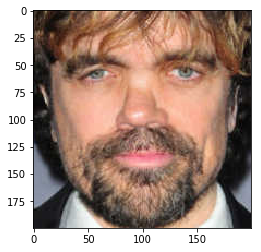

In [59]:
%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/prueba/tyrion.jpg', 'r')
imshow(np.asarray(pil_im))

y_testRes =['1-5', '6-12', '13-18', '19-25', '26-60', '+60']
y_test = [1,5,6]
X_test = np.empty((3,100,100,3))
X_test[0] = np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/prueba/bebe.jpg')).resize((100,100))).reshape(1,100,100,3)/255
X_test[1] = np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/prueba/tyrion.jpg')).resize((100,100))).reshape(1,100,100,3)/255
X_test[2] = np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/prueba/papa.png')).resize((100,100))).reshape(1,100,100,3)/255
predictions = model.predict(X_test)
for p,l in zip(predictions, y_test):
  print(p, "->", l)
  result = np.where(p == np.amax(p))[0]
  print("Predicción: ", y_testRes[int(result)], " ||| ", "Valor Real: ", y_testRes[l-1])

### Visualizamos cómo el Modelo ha ido adquiriendo *accuracy* y perdiendo *loss*.

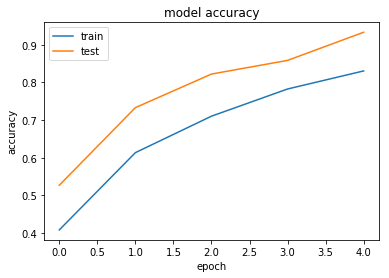

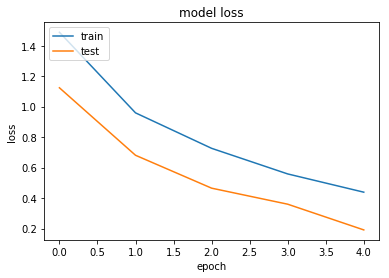

In [60]:
#accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Guardamos el Modelo:

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/models/facialage_model.h5')

## Segunda Idea de Modelo (Usando Keras VGG-16)

Hasta ahora hemos creado un modelo desde su inicio. Pero... ¿Y si partiéramos de una ***Red Neuronal existente*** y le añadiéramos las capas densas apropiadas para nuestro caso?

Se va a tratar de usar la Red Neuronal VGG-16:

### Imports
Repetimos algunos **imports** en caso de no haber ejecutado nada del Primer Modelo.

In [0]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from time import time
import numpy as np
import matplotlib.pyplot as plt

### Data Source
Repetimos la carga de datos en caso de no haber ejecutado nada del Primer Modelo.

In [62]:
train_data_dir = '/content/drive/My Drive/Colab Notebooks/datasets/facial_age'
validation_data_dir = '/content/drive/My Drive/Colab Notebooks/datasets/facial_age'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(100, 100),
        batch_size=64,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(100, 100),
        batch_size=32,
        class_mode='categorical')

Found 4746 images belonging to 6 classes.
Found 4746 images belonging to 6 classes.


### Model
#### Usamos Keras VGG-16

In [0]:
model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(100,100,3))
for layer in model_vgg16.layers[2:9]:
    layer.trainable = False
    
for layer in model_vgg16.layers[11:]:
    layer.trainable = False

#### Añadimos nuestras capas densas personalizadas después de las capas convolutivas de VGG-16:

In [64]:
x = Flatten()(model_vgg16.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(6, activation='softmax')(x)

model = Model(input=model_vgg16.input, output=x)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


### Training

In [65]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//20,
        epochs=18, 
        validation_data=validation_generator,
        validation_steps=train_generator.samples//32,
)

Epoch 1/18
237/237 [==============================] - 99s 420ms/step - loss: 1.6089 - acc: 0.3476 - val_loss: 1.1516 - val_acc: 0.5405
Epoch 2/18
237/237 [==============================] - 94s 398ms/step - loss: 1.0813 - acc: 0.5570 - val_loss: 0.8069 - val_acc: 0.6640
Epoch 3/18
237/237 [==============================] - 95s 401ms/step - loss: 0.9187 - acc: 0.6182 - val_loss: 0.7848 - val_acc: 0.6640
Epoch 4/18
237/237 [==============================] - 96s 405ms/step - loss: 0.8156 - acc: 0.6642 - val_loss: 0.7360 - val_acc: 0.6907
Epoch 5/18
237/237 [==============================] - 95s 403ms/step - loss: 0.7441 - acc: 0.6970 - val_loss: 0.6277 - val_acc: 0.7378
Epoch 6/18
237/237 [==============================] - 96s 405ms/step - loss: 0.6882 - acc: 0.7157 - val_loss: 0.5305 - val_acc: 0.7821
Epoch 7/18
237/237 [==============================] - 95s 402ms/step - loss: 0.6427 - acc: 0.7324 - val_loss: 0.5207 - val_acc: 0.7849
Epoch 8/18
237/237 [==============================] - 9

#### Cargamos el Modelo:

In [0]:
model = load_model('/content/drive/My Drive/Colab Notebooks/models/facialage_model_vgg16.h5')

### Test

In [66]:
# y_testReal = [5,15,25,35,45,55,65,75,85]
y_testRes =['1-5', '6-12', '13-18', '19-25', '26-60', '+60']
y_test = [1,3,4,5,5,5,6,6,6]
X_test = np.empty((9,100,100,3))
X_test[0] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/1/4882.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[1] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/3/49.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[2] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/4/51.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[3] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/5/5350.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[4] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/5/5394.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[5] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/5/5565.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[6] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/6/1265.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[7] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/6/1618.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[8] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/6/3412.png')).resize((100,100))).reshape(1,100,100,3)/255)

predictions = model.predict(X_test)
for p,l in zip(predictions, y_test):
  print(p, "->", l)
  result = np.where(p == np.amax(p))[0]
  print("Predicción: ", y_testRes[int(result)], " ||| ", "Valor Real: ", y_testRes[l-1])

[9.9999619e-01 3.8343528e-06 2.2435628e-12 6.3911716e-11 8.4886945e-18
 1.7604465e-14] -> 1
Predicción:  1-5  |||  Valor Real:  1-5
[2.5867877e-10 4.2689564e-03 9.8708898e-01 8.6349593e-03 7.0457695e-06
 2.9524808e-10] -> 3
Predicción:  13-18  |||  Valor Real:  13-18
[1.4685338e-06 5.7937694e-04 1.8800960e-01 7.7004522e-01 4.1339193e-02
 2.5060193e-05] -> 4
Predicción:  19-25  |||  Valor Real:  19-25
[5.0496626e-16 3.8630089e-11 4.8144358e-08 1.2998526e-04 9.9986851e-01
 1.4322616e-06] -> 5
Predicción:  26-60  |||  Valor Real:  26-60
[4.2251165e-26 1.4398345e-18 2.6131959e-12 2.4588337e-07 9.9999726e-01
 2.5244001e-06] -> 5
Predicción:  26-60  |||  Valor Real:  26-60
[9.9500844e-27 3.2015266e-20 2.0156772e-11 2.6176987e-05 9.9995303e-01
 2.0743259e-05] -> 5
Predicción:  26-60  |||  Valor Real:  26-60
[1.3632360e-20 2.4962599e-17 5.5922657e-17 3.7544756e-14 1.4150997e-04
 9.9985850e-01] -> 6
Predicción:  +60  |||  Valor Real:  +60
[1.0887461e-19 9.4099653e-18 3.9358534e-15 3.6546599e-14

[9.9999964e-01 3.8976148e-07 5.1269045e-15 6.4856927e-14 7.7604762e-18
 1.2194206e-14] -> 1
Predicción:  1-5  |||  Valor Real:  1-5
[1.3271471e-15 2.9794524e-08 2.2757256e-06 7.2746203e-05 8.4724319e-01
 1.5268175e-01] -> 5
Predicción:  26-60  |||  Valor Real:  26-60
[1.4679035e-19 9.6675326e-14 7.9875247e-12 2.5979434e-11 1.6290002e-03
 9.9837106e-01] -> 6
Predicción:  +60  |||  Valor Real:  +60


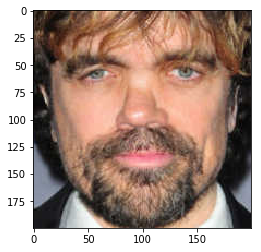

In [67]:
%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/prueba/tyrion.jpg', 'r')
imshow(np.asarray(pil_im))

y_testRes =['1-5', '6-12', '13-18', '19-25', '26-60', '+60']
y_test = [1,5,6]
X_test = np.empty((3,100,100,3))
X_test[0] = np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/prueba/bebe.jpg')).resize((100,100))).reshape(1,100,100,3)/255
X_test[1] = np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/prueba/tyrion.jpg')).resize((100,100))).reshape(1,100,100,3)/255
X_test[2] = np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/prueba/papa.png')).resize((100,100))).reshape(1,100,100,3)/255
predictions = model.predict(X_test)
for p,l in zip(predictions, y_test):
  print(p, "->", l)
  result = np.where(p == np.amax(p))[0]
  print("Predicción: ", y_testRes[int(result)], " ||| ", "Valor Real: ", y_testRes[l-1])

### Visualizamos cómo el Modelo ha ido adquiriendo *accuracy* y perdiendo *loss*.

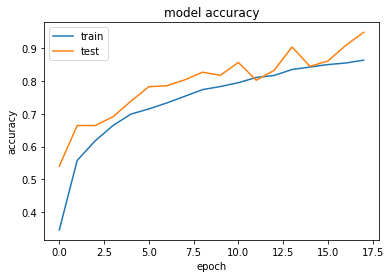

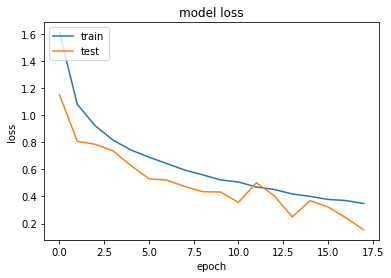

In [68]:
#accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Guardamos el Modelo:

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/models/facialage_model_vgg16.h5')